# ライブラリ

In [1]:
import os
import random
import sys

sys.path.append(
    "/Users/koroku/program/competition/signate/202402_samples/table/binary_classification"
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing.tools import convert_column_type
from src.preprocessing.encoder import ordinal_encoder
from src.preprocessing.missing_value import default_mv_processor
from src.training.xgb_training import trainer
from src.predict.xgb_predict import predictor
from src.save.save_model import save_model

RAW_DATA_DIR = "../data/raw"

OBJECT_VARIABLE = "Survived"

CONVERSION_DICT = {"Pclass": str, "SibSp": str, "Parch": str}

/var/folders/0v/ww1kbtnn51s3wxx7f3p9wm2m0000gn/T/ipykernel_75317/125256772.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# データの読み込み

In [2]:
df_train = pd.read_csv(
    os.path.join(RAW_DATA_DIR, "train.csv"), index_col=0
)
df_test = pd.read_csv(os.path.join(RAW_DATA_DIR, "test.csv"), index_col=0)
df_submit = pd.read_csv(
    os.path.join(RAW_DATA_DIR, "sample_submission.csv"),
    index_col=0,
    header=None,
)

# モデルの学習・予測

## データの準備

In [3]:
# データの型を変換する
df_train = convert_column_type(df_train, CONVERSION_DICT)
df_test = convert_column_type(df_test, CONVERSION_DICT)

# 欠損値処理
missing_cols_train = df_train.columns[df_train.isnull().any()].tolist()
missing_cols_test = df_test.columns[df_test.isnull().any()].tolist()
df_train = default_mv_processor(df_train, missing_cols_train)
df_test = default_mv_processor(df_test, missing_cols_test)

# 特徴量と正解ラベルに分割
y_train = df_train[OBJECT_VARIABLE]
X_train = df_train.drop([OBJECT_VARIABLE], axis=1)
X_test = df_test

# エンコーディング
cols = X_test.select_dtypes(include="object").columns.tolist()
X_train, X_test = ordinal_encoder(X_train, X_test, cols)

## 学習

In [4]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 5,
    "colsample_bytree": 0.50,
    "num_round": 1000,
    "seed": 42,
    "nthread": -1,
    "verbosity": 0,
}
models, f1 = trainer(X_train, y_train, params)

--------------------------
Fold 1
--------------------------
F1 Score (Training): 0.73523  (Validation): 0.70690
F1 Score (Training): 0.78947  (Validation): 0.76983
Valid Classification Report
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       110
           1       0.87      0.59      0.71        69

    accuracy                           0.81       179
   macro avg       0.83      0.77      0.78       179
weighted avg       0.82      0.81      0.80       179

--------------------------
Fold 2
--------------------------
F1 Score (Training): 0.75536  (Validation): 0.63636
F1 Score (Training): 0.80294  (Validation): 0.72553
Valid Classification Report
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       110
           1       0.83      0.51      0.64        68

    accuracy                           0.78       178
   macro avg       0.80      0.73      0.74       178
weighted avg   

# 重要度

In [5]:
feature_importances_dicts = [model.get_score(importance_type='gain') for model in models]
all_features = sorted(set().union(*(d.keys() for d in feature_importances_dicts)))
filled_importances = np.array([[d.get(feature, 0) for feature in all_features] for d in feature_importances_dicts])
mean_importances = np.mean(filled_importances, axis=0)
mean_importances_dict = dict(zip(all_features, mean_importances))
sorted_importances = sorted(mean_importances_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

Sex: 121.43515472412109
Pclass: 17.061454391479494
Cabin: 7.795292663574219
Age: 7.443636131286621
Fare: 5.644822502136231
Parch: 3.5493953704833983
SibSp: 3.506972599029541
Embarked: 3.2107289314270018
Ticket: 2.078575849533081
Name: 1.7976479053497314


In [6]:
sorted_features = [feature[0] for feature in sorted_importances]
sorted_importances = [importance[1] for importance in sorted_importances]

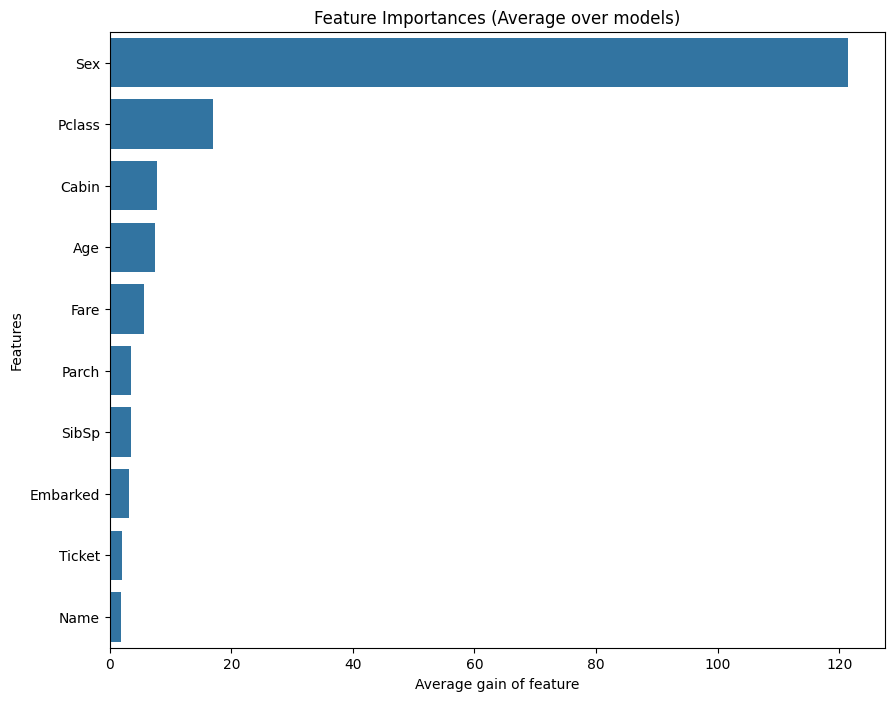

In [7]:
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title('Feature Importances (Average over models)')
plt.xlabel('Average gain of feature')
plt.ylabel('Features')
plt.show()

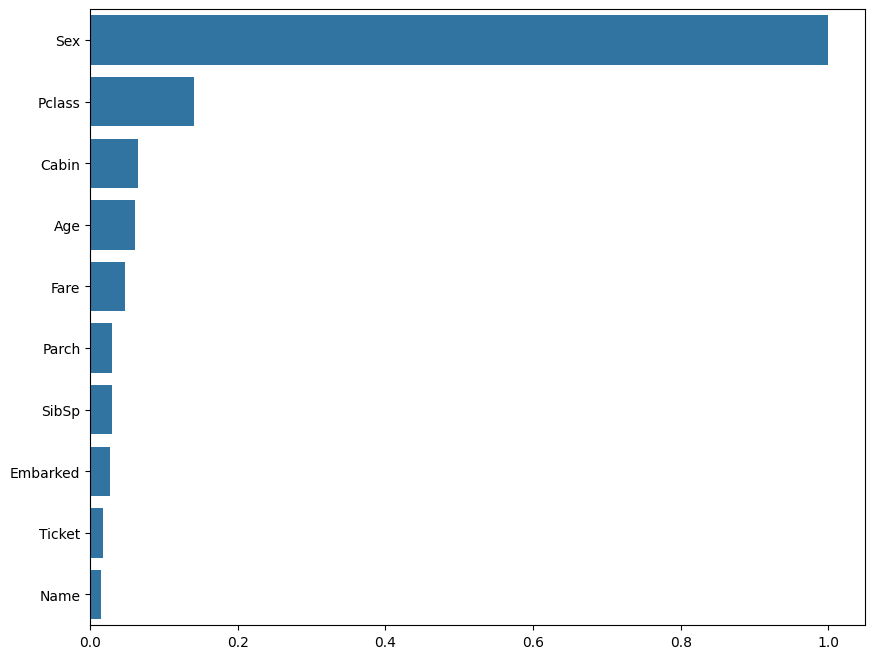

In [8]:
max_importance = max(sorted_importances)
importance_ratios = [x / max_importance for x in sorted_importances]
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_ratios, y=sorted_features)
plt.show()

In [9]:
important_features = [name  for name, ratio in zip(sorted_features, importance_ratios) if ratio>0.1]
important_features

['Sex', 'Pclass']

In [10]:
important_features = [name  for name, ratio in zip(sorted_features, importance_ratios) if ratio>0.2]
important_features

['Sex']